<a href="https://colab.research.google.com/github/DevHyunseo/PoscoAcademy_Bigdata/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B83_%EC%A2%85%ED%95%A9%EC%8B%A4%EC%8A%B5(%EB%8C%80%ED%98%95%EB%A7%88%ED%8A%B8)RFM%20score%20%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from datetime import datetime
import warnings
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

sns.set_palette('Pastel1')
plt.rcParams['font.family'] = 'NanumGothic'
matplotlib.rc("font",family = "NanumGothic")

# 0. 데이터 불러오기

In [ ]:
# 전처리 완료된 파일 로드
df = pd.read_csv("/home/piai/다운로드/pre_member_data.csv")
dfm =  pd.read_csv("/home/piai/다운로드/pre_product_data.csv")

In [ ]:
# 데이터 확인
df.head()

,회원번호,조합원상태,주소,성별,연령,배송서비스신청여부,모바일알람여부,Gold_member,구,동,연령대,지역
0,1000012800,정상회원,수지구-풍덕천동,여,58.0,미신청,.,normal,수지구,풍덕천동,50대,수지 지역
1,1000103744,정상회원,처인구-고림동,여,34.0,미신청,.,normal,처인구,고림동,30대,주변 지역
2,1000122304,정상회원,광주-기타,여,38.0,미신청,.,normal,광주,기타,30대,먼 지역
3,1000163136,정상회원,수지구-동천동,여,73.0,미신청,.,normal,수지구,동천동,70대 이상,수지 지역
4,1000281920,정상회원,수지구-풍덕천동,여,42.0,신청,.,normal,수지구,풍덕천동,40대,수지 지역


In [ ]:
# 데이터 확인
dfm.head()

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자,유기농 물품
0,2023-01-06,220954944,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3829,매장A,10:32,NaN,X
1,2023-01-06,89023040,정상회원,채소,열매채소,단호박/손질,단호박(깍뚝썰기/300g),1.0,4977,매장A,10:41,NaN,X
2,2023-01-06,354941440,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,11:00,NaN,O
3,2023-01-06,786634048,탈퇴회원,반찬,어묵/묵,묵,도토리묵(420g:1모),1.0,7083,매장A,11:28,NaN,X
4,2023-01-06,438543104,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,11:59,NaN,O


# 1. RFM score 계산을 위한 파생변수 생성

### (1) R_score 파생변수 (최근방문일그룹화) 생성
- 최근방문일그룹화 파생변수 생성
- 회원번호별 최근 방문일을 기준으로 그룹 설정
- 최근 방문일 14일 이내 : 5점
- 최근 방문일 30일 이내 : 4점
- 최근 방문일 60일 이내 : 3점
- 최근 방문일 90일 이내 : 2점
- 그 외 : 1점

In [ ]:
# 공급일자를 바탕으로 년 월 일로 나눈다
dfm[['년','월','일']] = dfm['공급일자'].str.split('-', 2, expand=True)

In [ ]:
# 최근 방문일자 변수 생성

# '년', '월', '일'을 결합하여 '방문일' 컬럼 생성
dfm['최근방문일'] = pd.to_datetime(dfm['년'] + '-' + dfm['월'] + '-' + dfm['일'], format='%Y-%m-%d')

# 기준 날짜 설정
reference_date = pd.to_datetime('2023-11-04')

# 기준 날짜와 방문일의 차이 계산
dfm['일차'] = (reference_date - dfm['최근방문일']).dt.days

# 각 회원번호별로 가장 최근 방문일 찾기
recent_visits = dfm.loc[dfm.groupby('회원번호')['최근방문일'].idxmax()].reset_index(drop=True)

# 그룹화 조건에 따라 그룹 할당
def assign_group(days):
    if days <= 14:
        return 5
    elif days <= 30:
        return 4
    elif days <= 60:
        return 3
    elif days <= 90:
        return 2
    else:
        return 1

# 최근방문일그룹화 변수 생성
recent_visits['최근방문일그룹화'] = recent_visits['일차'].apply(assign_group)

# 최근 방문일 기준으로 그룹 정보를 원래 데이터프레임에 추가
df = pd.merge(df, recent_visits[['회원번호',"일차" ,'최근방문일그룹화']], on='회원번호', how='left')

# 결과 출력
df

,회원번호,조합원상태,주소,성별,연령,배송서비스신청여부,모바일알람여부,Gold_member,구,동,연령대,지역,일차,최근방문일그룹화
0,1000012800,정상회원,수지구-풍덕천동,여,58.0,미신청,.,normal,수지구,풍덕천동,50대,수지 지역,139.0,1.0
1,1000103744,정상회원,처인구-고림동,여,34.0,미신청,.,normal,처인구,고림동,30대,주변 지역,18.0,4.0
2,1000122304,정상회원,광주-기타,여,38.0,미신청,.,normal,광주,기타,30대,먼 지역,0.0,5.0
3,1000163136,정상회원,수지구-동천동,여,73.0,미신청,.,normal,수지구,동천동,70대 이상,수지 지역,0.0,5.0
4,1000281920,정상회원,수지구-풍덕천동,여,42.0,신청,.,normal,수지구,풍덕천동,40대,수지 지역,25.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,999682432,탈퇴회원,수지구-동천동,여,47.0,미신청,.,normal,수지구,동천동,40대,수지 지역,296.0,1.0
11548,999721408,정상회원,수지구-동천동,여,43.0,미신청,.,normal,수지구,동천동,40대,수지 지역,40.0,3.0
11549,999738112,정상회원,수지구-성복동,여,67.0,미신청,.,normal,수지구,성복동,60대,수지 지역,13.0,5.0
11550,999754816,정상회원,수지구-상현동,여,44.0,신청,.,normal,수지구,상현동,40대,수지 지역,9.0,5.0


### (2) F score 파생변수 (방문횟수그룹) 생성
- 방문횟수그룹 변수 생성

In [ ]:
# 총 방문횟수 변수 생성

# 총 방문횟수 계산 함수
def calculate_store_visits(data):
    # 회원번호와 날짜 별로 중복 제거
    unique_visits = data.drop_duplicates(subset=['회원번호', '공급일자'])
    # 회원번호 별로 그룹화하고 각 그룹의 크기를 계산하여 방문 횟수를 카운트
    visits_count = unique_visits.groupby('회원번호').size().reset_index(name='총방문횟수')
    return visits_count

# 데이터프레임 'dfm' 사용 예제
store_visits = calculate_store_visits(dfm)
print(store_visits)

# 'df'에 'store_visits'를 병합하여 각 회원의 총 방문 횟수를 추가
df = pd.merge(df, store_visits[['회원번호', '총방문횟수']], on='회원번호', how='left')

             회원번호  총방문횟수
0        18613824      1
1        18764160      7
2        18792000      1
3        18942336     12
4        18949760      1
...           ...    ...
11538  1644772352      1
11539  1644957952      1
11540  1670400000    279
11541  1670606016      6
11542  1670620864     10

[11543 rows x 2 columns]


In [ ]:
# 총 방문횟수를 기준으로 5개의 그룹으로 나누기
df['방문횟수 그룹'], bins = pd.qcut(df['총방문횟수'], q=[0, 0.3, 0.5, 0.7, 0.85, 1], labels=[1, 2, 3, 4, 5], retbins=True)

# 각 구간의 경계값을 표시
bin_ranges = [(round(bins[i], 2), round(bins[i+1], 2)) for i in range(len(bins)-1)]
group_labels = [f'Group {i+1}' for i in range(len(bin_ranges))]

# 경계값을 데이터프레임으로 변환
boundaries_df = pd.DataFrame({
    'Group': group_labels,
    'Range': bin_ranges
})

# 결과 출력
print("방문횟수 그룹 경계값 (총방문횟수 수치):")
print(boundaries_df)

방문횟수 그룹 경계값 (총방문횟수 수치):
     Group          Range
0  Group 1     (1.0, 2.0)
1  Group 2     (2.0, 5.0)
2  Group 3    (5.0, 13.0)
3  Group 4   (13.0, 26.0)
4  Group 5  (26.0, 279.0)


### (3) M score 파생변수 (구매금액그룹화) 생성

In [ ]:
# 회원번호별 총 구매금액 변수 생성

# 회원번호별 구매금액 합산 후 변수 생성
total_purchase_by_member = dfm.groupby('회원번호')['구매금액'].sum().reset_index()
total_purchase_by_member.columns = ['회원번호', '총구매금액']

# 원래 데이터프레임 dfm에 총구매금액 정보 추가
dfm = pd.merge(dfm, total_purchase_by_member, on='회원번호', how='left')
df = pd.merge(df, total_purchase_by_member, on='회원번호', how='left')

df

,회원번호,조합원상태,주소,성별,연령,배송서비스신청여부,모바일알람여부,Gold_member,구,동,연령대,지역,일차,최근방문일그룹화,총방문횟수,방문횟수 그룹,총구매금액
0,1000012800,정상회원,수지구-풍덕천동,여,58.0,미신청,.,normal,수지구,풍덕천동,50대,수지 지역,139.0,1.0,1.0,1,7658.0
1,1000103744,정상회원,처인구-고림동,여,34.0,미신청,.,normal,처인구,고림동,30대,주변 지역,18.0,4.0,1.0,1,36948.0
2,1000122304,정상회원,광주-기타,여,38.0,미신청,.,normal,광주,기타,30대,먼 지역,0.0,5.0,15.0,4,142831.0
3,1000163136,정상회원,수지구-동천동,여,73.0,미신청,.,normal,수지구,동천동,70대 이상,수지 지역,0.0,5.0,4.0,2,138892.0
4,1000281920,정상회원,수지구-풍덕천동,여,42.0,신청,.,normal,수지구,풍덕천동,40대,수지 지역,25.0,4.0,28.0,5,632554.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,999682432,탈퇴회원,수지구-동천동,여,47.0,미신청,.,normal,수지구,동천동,40대,수지 지역,296.0,1.0,1.0,1,39246.0
11548,999721408,정상회원,수지구-동천동,여,43.0,미신청,.,normal,수지구,동천동,40대,수지 지역,40.0,3.0,2.0,1,43457.0
11549,999738112,정상회원,수지구-성복동,여,67.0,미신청,.,normal,수지구,성복동,60대,수지 지역,13.0,5.0,9.0,3,152960.0
11550,999754816,정상회원,수지구-상현동,여,44.0,신청,.,normal,수지구,상현동,40대,수지 지역,9.0,5.0,21.0,4,641334.0


In [ ]:
#총 구매금액을 기준으로 5개의 그룹으로 나누기
df['구매금액그룹'], bins = pd.qcut(df['총구매금액'], q=[0, 0.3, 0.5, 0.7, 0.85, 1], labels=[1, 2, 3, 4, 5], retbins=True)

# 각 구간의 경계값을 표시
bin_ranges = [(round(bins[i], 2), round(bins[i+1], 2)) for i in range(len(bins)-1)]
group_labels = [f'Group {i+1}' for i in range(len(bin_ranges))]

# 각 그룹의 총방문횟수 구하기
total_visits_by_group = df.groupby('구매금액그룹')["총구매금액"].sum().reset_index()

# 경계값을 데이터프레임으로 변환
boundaries_df = pd.DataFrame({
    'Group': group_labels,
    'Range': bin_ranges
})

# 그룹별 총방문횟수를 병합
boundaries_df = boundaries_df.merge(total_visits_by_group, left_on='Group', right_on='구매금액그룹', how='left').drop(columns='구매금액그룹')

# 결과 출력
print("구매금액 그룹 경계값 (총구매금액 수치) 및 그룹별 총방문횟수:")
print(boundaries_df)

구매금액 그룹 경계값 (총구매금액 수치) 및 그룹별 총방문횟수:
     Group                    Range  총구매금액
0  Group 1         (766.0, 37071.0)    NaN
1  Group 2       (37071.0, 96487.0)    NaN
2  Group 3      (96487.0, 241249.9)    NaN
3  Group 4    (241249.9, 548101.55)    NaN
4  Group 5  (548101.55, 14207898.0)    NaN


In [ ]:
# 거래데이터가 삭제되어 고객 정보가 없기 때문에 결측값 발생
df.isnull().sum()

회원번호            0
조합원상태           0
주소              0
성별              0
연령              0
배송서비스신청여부       0
모바일알람여부         0
Gold_member     0
구               0
동               0
연령대             0
지역              0
일차             12
최근방문일그룹화       12
총방문횟수          12
방문횟수 그룹        12
총구매금액          12
구매금액그룹         12
dtype: int64

In [ ]:
# 결측 데이터 확인
missing_data = df[df.isnull().any(axis=1)]
missing_data

,회원번호,조합원상태,주소,성별,연령,배송서비스신청여부,모바일알람여부,Gold_member,구,동,연령대,지역,일차,최근방문일그룹화,총방문횟수,방문횟수 그룹,총구매금액,구매금액그룹
1164,1147481280,정상회원,수지구-동천동,여,67.0,미신청,.,normal,수지구,동천동,60대,수지 지역,NaN,NaN,NaN,NaN,NaN,NaN
3164,1458554304,정상회원,기타-기타,여,50.0,미신청,.,normal,기타,기타,50대,먼 지역,NaN,NaN,NaN,NaN,NaN,NaN
3581,1516619264,정상회원,기타-기타,여,40.0,미신청,.,normal,기타,기타,40대,먼 지역,NaN,NaN,NaN,NaN,NaN,NaN
4150,1582544384,정상회원,수지구-동천동,여,36.0,미신청,.,normal,수지구,동천동,30대,수지 지역,NaN,NaN,NaN,NaN,NaN,NaN
4440,1636303424,정상회원,수지구-풍덕천동,여,41.0,미신청,수신,normal,수지구,풍덕천동,40대,수지 지역,NaN,NaN,NaN,NaN,NaN,NaN
4813,20993216,정상회원,수지구-풍덕천동,여,52.0,미신청,.,normal,수지구,풍덕천동,50대,수지 지역,NaN,NaN,NaN,NaN,NaN,NaN
6696,472758464,정상회원,수지구-신봉동,여,49.0,미신청,.,normal,수지구,신봉동,50대,수지 지역,NaN,NaN,NaN,NaN,NaN,NaN
7182,554437312,정상회원,수지구-죽전동,여,63.0,미신청,.,normal,수지구,죽전동,60대,수지 지역,NaN,NaN,NaN,NaN,NaN,NaN
7367,57302144,정상회원,분당구-백현동,여,55.0,미신청,.,normal,분당구,백현동,50대,주변 지역,NaN,NaN,NaN,NaN,NaN,NaN
7630,603424576,정상회원,기타-기타,여,36.0,미신청,.,normal,기타,기타,30대,먼 지역,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 결측 데이터 제거
df=df.dropna()

In [ ]:
# 각 그룹 변수의 타입 변환
df['구매금액그룹'] = df['구매금액그룹'].astype(int)
df['최근방문일그룹화'] = df['최근방문일그룹화'].astype(int)
df['방문횟수 그룹'] = df['방문횟수 그룹'].astype(int)

In [ ]:
# RFM score를 위한 각 그룹 변수 값 합산
df['RFM_Score'] = df['최근방문일그룹화'] + df['구매금액그룹'] + df['방문횟수 그룹']

# 2. K-means 클러스터링 기반 RFM 가중치 계산

xr: 1.85, xf: 2.8, xm: 2.35


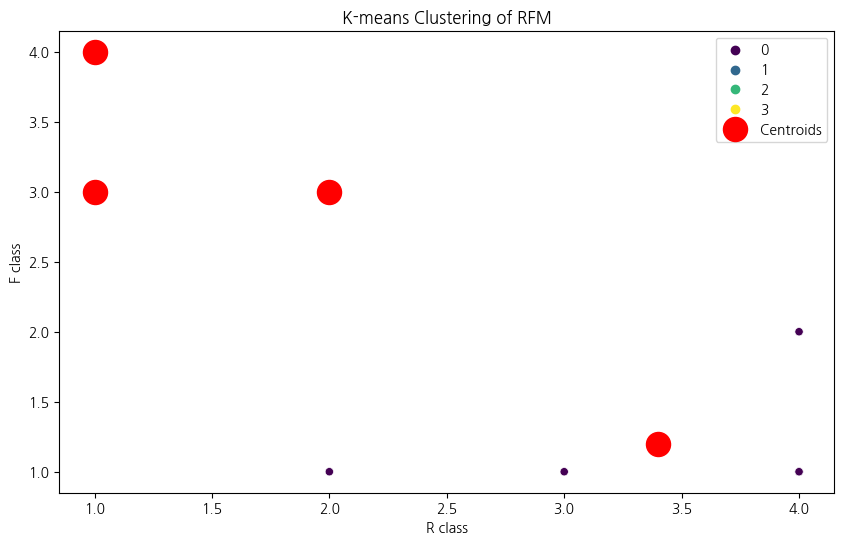

In [ ]:
# 데이터 로드
dfm =  pd.read_csv("/home/piai/다운로드/pre_product_data.csv")

# 예시 데이터프레임 생성 (실제 데이터를 로드하는 것으로 대체해야 함)
data = {
    'R class': [3, 1, 2, 1, 4, 4, 4, 1, 2, 2],
    'F class': [1, 3, 1, 4, 1, 1, 2, 4, 3, 3],
    'M class': [1, 1, 2, 4, 1, 2, 1, 4, 3, 3]
}
df_rfm = pd.DataFrame(data)

# 필요한 열만 추출
X = df_rfm[['R class', 'F class', 'M class']]

# K-means 클러스터링 수행 (파라미터 조정)
kmeans = KMeans(
    n_clusters=4,          # 클러스터의 개수
    init='k-means++',      # 초기 클러스터 중심 설정 방법
    n_init=20,             # 알고리즘 실행 횟수
    max_iter=400,          # 최대 반복 횟수
    tol=1e-4,              # 수렴 기준 허용 오차
    random_state=42        # 무작위 초기 클러스터 중심 설정을 위한 시드
).fit(X)

# 클러스터 할당
df_rfm['Cluster'] = kmeans.labels_

# 클러스터 중심 계산
cluster_centers = kmeans.cluster_centers_

# 각 클러스터의 가중치 계산
cluster_weights = cluster_centers.mean(axis=0)
xr, xf, xm = cluster_weights

print(f"xr: {xr}, xf: {xf}, xm: {xm}")

# 클러스터 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rfm, x='R class', y='F class', hue='Cluster', palette='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=300, c='red', label='Centroids')
plt.title('K-means Clustering of RFM')
plt.legend()
plt.show()

In [ ]:
# 점수 계산
df['점수'] = (0.268 * df['최근방문일그룹화'] + 0.358 * df['구매금액그룹'] + 0.373 * df['방문횟수 그룹'])

# 결과 출력
print(df)

             회원번호 조합원상태        주소 성별    연령 배송서비스신청여부 모바일알람여부 Gold_member    구  \
0        99995712  정상회원   수지구-상현동  여  66.0       미신청       .      normal  수지구   
1       629226688  정상회원   수지구-상현동  여  56.0       미신청      수신      normal  수지구   
2      1245489216  정상회원  수지구-풍덕천동  여  50.0       미신청      수신      normal  수지구   
3       620724352  정상회원   수지구-동천동  여  61.0       미신청       .      normal  수지구   
4      1245411264  정상회원  수지구-풍덕천동  여  35.0       미신청      수신      normal  수지구   
...           ...   ...       ... ..   ...       ...     ...         ...  ...   
11535  1121439744  정상회원     기타-기타  여  33.0       미신청      수신      normal   기타   
11536   762322304  정상회원   수지구-신봉동  여  51.0       미신청       .      normal  수지구   
11537  1361324032  정상회원   수지구-상현동  여  38.0       미신청       .      normal  수지구   
11538  1121217024  정상회원     기타-기타  여  43.0       미신청       .      normal   기타   
11539  1000012800  정상회원  수지구-풍덕천동  여  58.0       미신청       .      normal  수지구   

          동  ...     일차 최근방

In [ ]:
# 점수 계산
df['점수'] = (0.268 * df['최근방문일그룹화'] + 0.358 * df['구매금액그룹'] + 0.373 * df['방문횟수 그룹'])

# 점수를 기준으로 데이터프레임 정렬
df = df.sort_values('점수', ascending=False).reset_index(drop=True)

# 각 구간의 경계값 설정 (10%, 20%, 30%, 40%)
quantiles = [0, 0.1, 0.3, 0.6, 1.0]

# 구간별 라벨 설정
labels = ['나무', '열매', '잎새', '새싹']

# 점수 기준으로 각 구간에 라벨 부여
df['등급'] = pd.qcut(df.index / len(df), q=quantiles, labels=labels)

# 결과 출력
print(df)

             회원번호 조합원상태        주소 성별    연령 배송서비스신청여부 모바일알람여부 Gold_member    구  \
0        99995712  정상회원   수지구-상현동  여  66.0       미신청       .      normal  수지구   
1       626257088  정상회원  수지구-풍덕천동  여  78.0       미신청       .         VIP  수지구   
2      1245489216  정상회원  수지구-풍덕천동  여  50.0       미신청      수신      normal  수지구   
3       620724352  정상회원   수지구-동천동  여  61.0       미신청       .      normal  수지구   
4      1245411264  정상회원  수지구-풍덕천동  여  35.0       미신청      수신      normal  수지구   
...           ...   ...       ... ..   ...       ...     ...         ...  ...   
11535  1121439744  정상회원     기타-기타  여  33.0       미신청      수신      normal   기타   
11536   762322304  정상회원   수지구-신봉동  여  51.0       미신청       .      normal  수지구   
11537  1361324032  정상회원   수지구-상현동  여  38.0       미신청       .      normal  수지구   
11538  1121217024  정상회원     기타-기타  여  43.0       미신청       .      normal   기타   
11539  1000012800  정상회원  수지구-풍덕천동  여  58.0       미신청       .      normal  수지구   

          동  ...     일차 최근방

In [ ]:
# 각 등급별 고객 수 확인
df["등급"].value_counts()

새싹    4616
잎새    3462
열매    2308
나무    1154
Name: 등급, dtype: int64

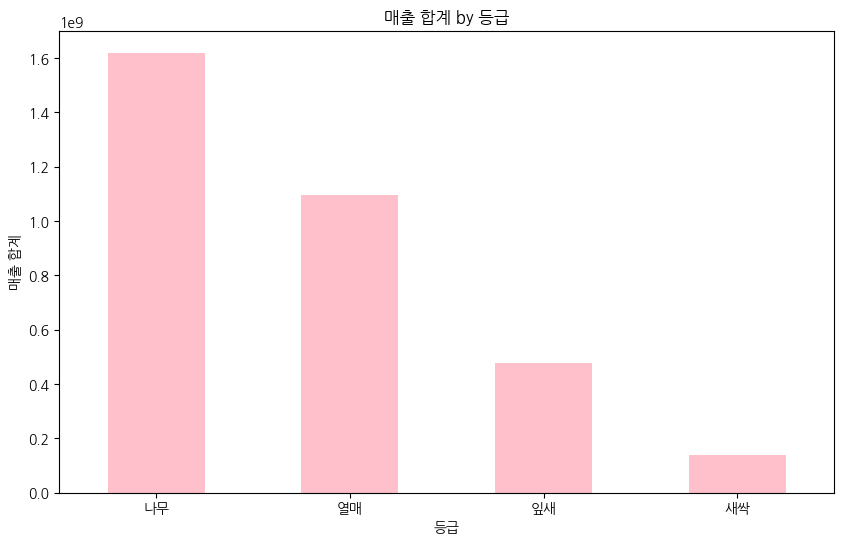

In [ ]:
# 각 등급별로 매출 합계 계산
sales_by_grade = df.groupby('등급')['총구매금액'].sum()

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sales_by_grade.plot(kind='bar', color='pink')
plt.title('매출 합계 by 등급')
plt.xlabel('등급')
plt.ylabel('매출 합계')
plt.xticks(rotation=0)
plt.show()

새싹    4616
잎새    3462
열매    2308
나무    1154
Name: 등급, dtype: int64


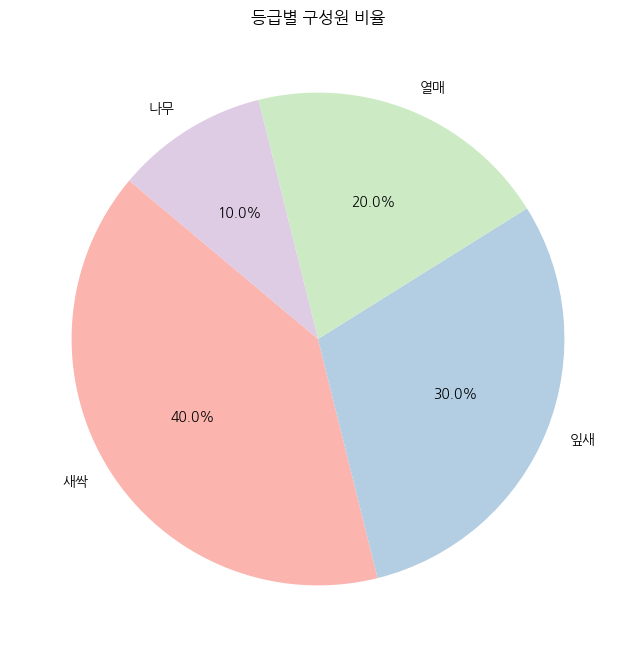

In [ ]:
# 각 등급별 구성원 수 계산
members_by_grade = df['등급'].value_counts()

# 결과 출력
print(members_by_grade)

# 파이 차트 그리기
plt.figure(figsize=(8, 8))
members_by_grade.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('등급별 구성원 비율')
plt.ylabel('')  # y축 레이블 제거
plt.show()

나무    1154
열매    2308
잎새    3462
새싹    4616
Name: 등급, dtype: int64


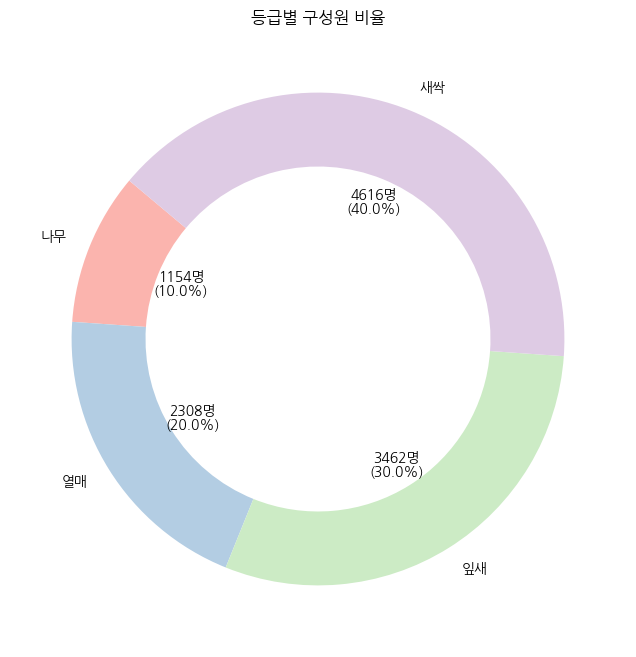

In [ ]:
# 각 등급별 구성원 수 계산
members_by_grade = df['등급'].value_counts().sort_index()

# 결과 출력
print(members_by_grade)

# 파이 차트 그리기
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    members_by_grade,
    labels=members_by_grade.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.3)  # 도넛형으로 만들기 위해 사용
)

# 등급별 사람 수 추가
for i, aut in enumerate(autotexts):
    aut.set_text(f'{members_by_grade.values[i]}명\n({aut.get_text()})')

plt.title('등급별 구성원 비율')
plt.show()

# 3. RFM 산출 결과를 바탕으로 고객 등급 결정

등급별 구성원 수:
나무    1154
열매    2308
잎새    3462
새싹    4616
Name: 등급, dtype: int64

등급별 매출:
등급
나무    1.619980e+09
열매    1.096175e+09
잎새    4.791350e+08
새싹    1.396634e+08
Name: 총구매금액, dtype: float64


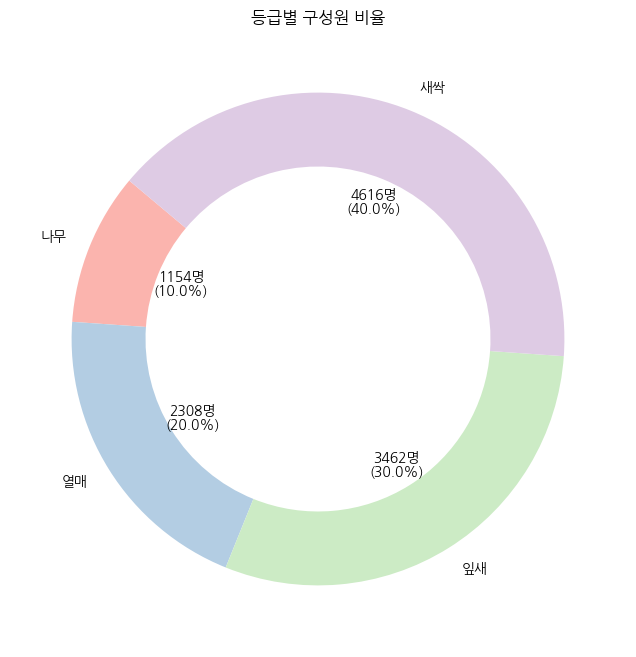

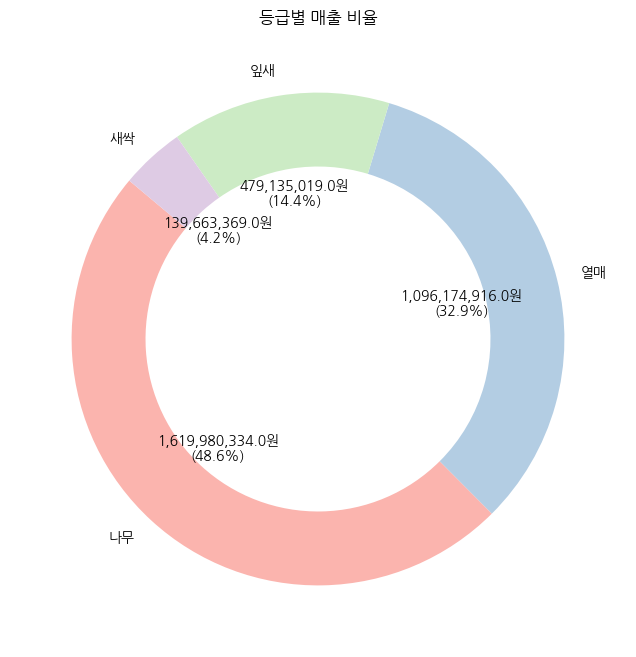

In [ ]:
# 각 등급별 구성원 수 계산
members_by_grade = df['등급'].value_counts().sort_index()

# 각 등급별 매출 합계 계산
sales_by_grade = df.groupby('등급')['총구매금액'].sum().sort_index()

# 결과 출력
print("등급별 구성원 수:")
print(members_by_grade)
print("\n등급별 매출:")
print(sales_by_grade)

# 등급별 구성원 수 파이 차트 그리기
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    members_by_grade,
    labels=members_by_grade.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.3)  # 도넛형으로 만들기 위해 사용
)

# 등급별 사람 수 추가
for i, aut in enumerate(autotexts):
    aut.set_text(f'{members_by_grade.values[i]}명\n({aut.get_text()})')

plt.title('등급별 구성원 비율')
plt.show()

# 등급별 매출 파이 차트 그리기
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sales_by_grade,
    labels=sales_by_grade.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.3)  # 도넛형으로 만들기 위해 사용
)

for i, aut in enumerate(autotexts):
    aut.set_text(f'{sales_by_grade.values[i]:,}원\n({aut.get_text()})')

plt.title('등급별 매출 비율')
plt.show()

등급별 구성원 수:
나무    1154
열매    2308
잎새    3462
새싹    4616
Name: 등급, dtype: int64

등급별 매출:
등급
나무    5770
열매    9480
잎새    9302
새싹    6028
Name: 구매금액그룹, dtype: int64

등급별 경계값:
   등급       경계값
0  나무  0.099991
1  열매  0.299974
2  잎새  0.599948
3  새싹  0.999913


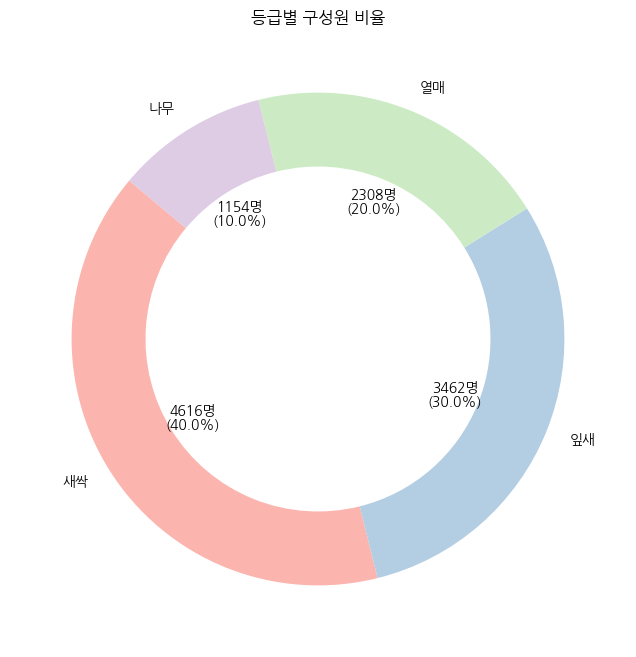

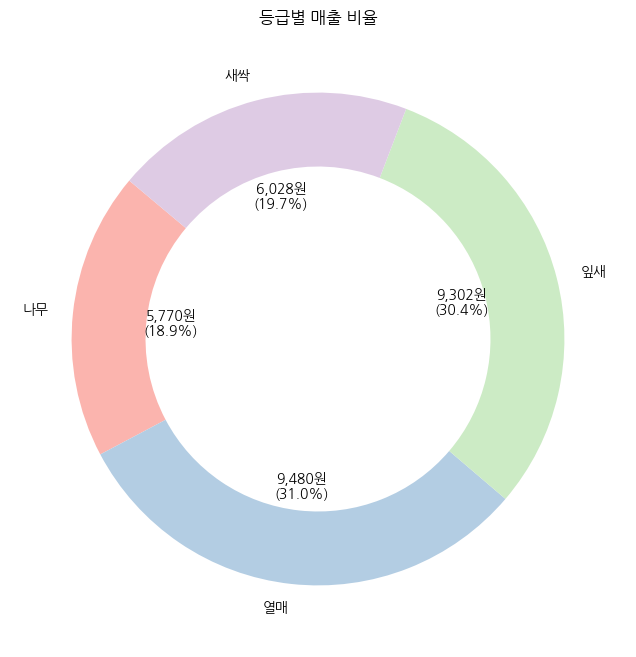

In [ ]:
# VIP 점수 기준으로 각 구간에 라벨 부여 및 경계값 확인
df['등급'], bins = pd.qcut(df.index / len(df), q=quantiles, labels=labels, retbins=True)

# 결과 출력
print("등급별 구성원 수:")
print(df['등급'].value_counts().sort_index())
print("\n등급별 매출:")
print(df.groupby('등급')['구매금액그룹'].sum().sort_index())

# 경계값을 데이터프레임으로 변환하여 출력
boundaries = pd.DataFrame({
    '등급': ['나무', '열매', '잎새', '새싹'],
    '경계값': bins[1:]  # 첫 번째 경계값은 0이므로 제외
})

print("\n등급별 경계값:")
print(boundaries)

# 파이 차트 그리기 (등급별 구성원 수)
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    df['등급'].value_counts(),
    labels=df['등급'].value_counts().index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.3)
)

for i, aut in enumerate(autotexts):
    aut.set_text(f'{df["등급"].value_counts().values[i]}명\n({aut.get_text()})')

plt.title('등급별 구성원 비율')
plt.show()

# 파이 차트 그리기 (등급별 매출)
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    df.groupby('등급')['구매금액그룹'].sum(),
    labels=df.groupby('등급')['구매금액그룹'].sum().index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.3)
)

for i, aut in enumerate(autotexts):
    aut.set_text(f'{df.groupby("등급")["구매금액그룹"].sum().values[i]:,}원\n({aut.get_text()})')

plt.title('등급별 매출 비율')
plt.show()

# 5. 최종 등급 산출

## (1) 나무

In [ ]:
df_vip = df[df["등급"]=="나무"]

In [ ]:
df_vip.describe()

,회원번호,연령,일차,최근방문일그룹화,총방문횟수,방문횟수 그룹,총구매금액,구매금액그룹,RFM_Score,VIP점수,점수
count,1.154000e+03,1154.000000,1154.000000,1154.0,1154.000000,1154.0,1.154000e+03,1154.0,1154.0,1.154000e+03,1.154000e+03
mean,6.940345e+08,52.137782,3.692374,5.0,54.863951,5.0,1.403796e+06,5.0,15.0,4.995000e+00,4.995000e+00
std,4.246933e+08,11.500183,3.599146,0.0,27.408693,0.0,1.025622e+06,0.0,0.0,8.885635e-14,8.885635e-14
min,1.962720e+07,25.000000,0.000000,5.0,27.000000,5.0,5.481160e+05,5.0,15.0,4.995000e+00,4.995000e+00
25%,3.439623e+08,44.000000,1.000000,5.0,37.000000,5.0,7.893765e+05,5.0,15.0,4.995000e+00,4.995000e+00
50%,6.806435e+08,50.000000,2.000000,5.0,47.000000,5.0,1.094127e+06,5.0,15.0,4.995000e+00,4.995000e+00
75%,1.007820e+09,60.000000,6.000000,5.0,62.000000,5.0,1.612153e+06,5.0,15.0,4.995000e+00,4.995000e+00
max,1.670400e+09,92.000000,14.000000,5.0,279.000000,5.0,1.420790e+07,5.0,15.0,4.995000e+00,4.995000e+00


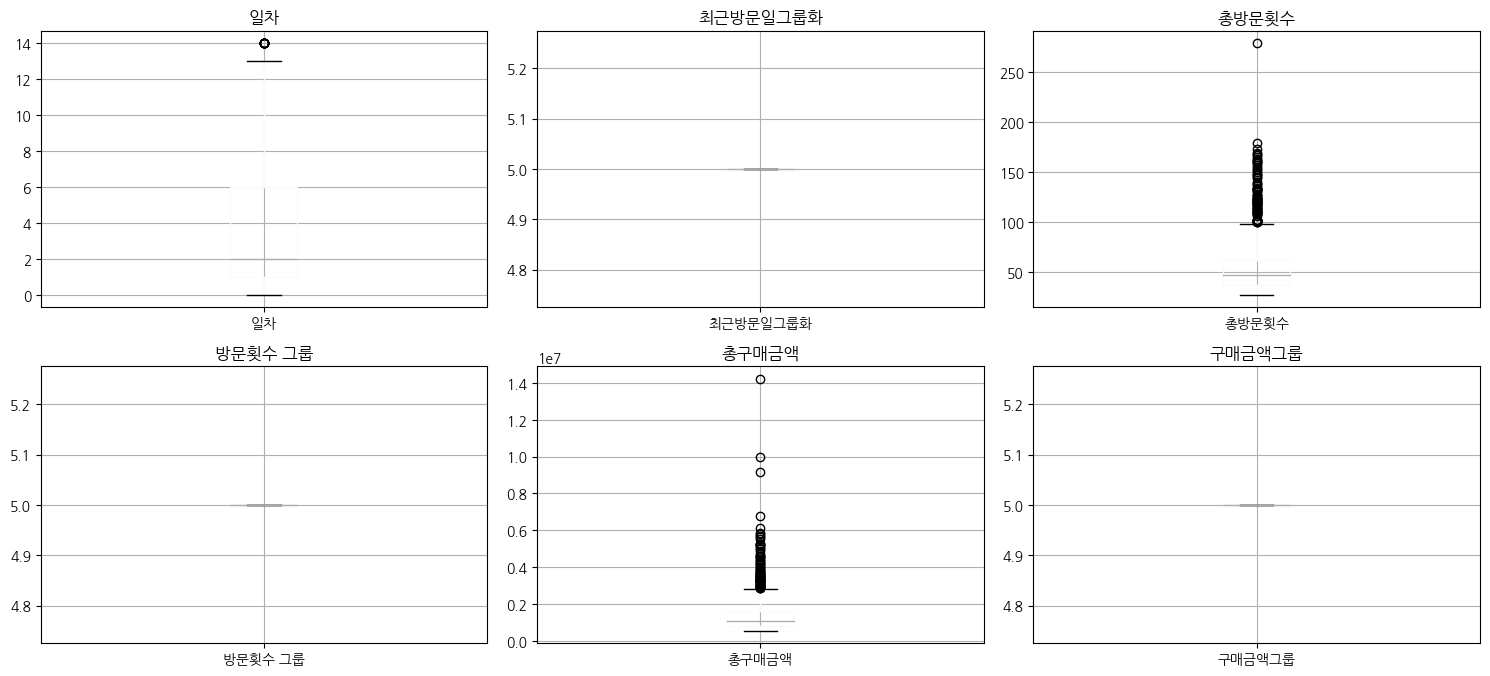

In [ ]:
# 박스 플롯 그리기 (각 열별로 개별 플롯)
columns = ['일차', '최근방문일그룹화', '총방문횟수', '방문횟수 그룹', '총구매금액', '구매금액그룹']
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    df_vip.boxplot(column=[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### 최종 나무 등급 결과

- vip등급의 일자 커트라인 14
- 횟수 27
- 금액 5.481160e+05

## (2) 열매

In [ ]:
df_gold = df[df["등급"]=="열매"]

In [ ]:
df_gold.describe()

,회원번호,연령,일차,최근방문일그룹화,총방문횟수,방문횟수 그룹,총구매금액,구매금액그룹,RFM_Score,VIP점수,점수
count,2.308000e+03,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2.308000e+03,2308.000000,2308.000000,2308.000000,2308.000000
mean,7.724533e+08,50.815858,13.761698,4.522964,22.334489,4.099220,4.749458e+05,4.107452,12.729636,4.211631,4.211631
std,4.229829e+08,11.695952,14.253281,0.698560,12.043984,0.597016,3.636474e+05,0.600300,1.074449,0.360607,0.360607
min,1.894234e+07,17.000000,0.000000,1.000000,6.000000,3.000000,1.006040e+05,3.000000,11.000000,3.623000,3.623000
25%,4.309558e+08,42.000000,4.000000,4.000000,15.000000,4.000000,2.845520e+05,4.000000,12.000000,3.906000,3.906000
50%,7.618564e+08,48.000000,9.000000,5.000000,20.000000,4.000000,3.967095e+05,4.000000,13.000000,4.264000,4.264000
75%,1.075554e+09,58.000000,19.000000,5.000000,26.000000,4.000000,5.407930e+05,4.000000,14.000000,4.622000,4.622000
max,1.640075e+09,106.000000,127.000000,5.000000,166.000000,5.000000,5.711555e+06,5.000000,15.000000,4.995000,4.995000


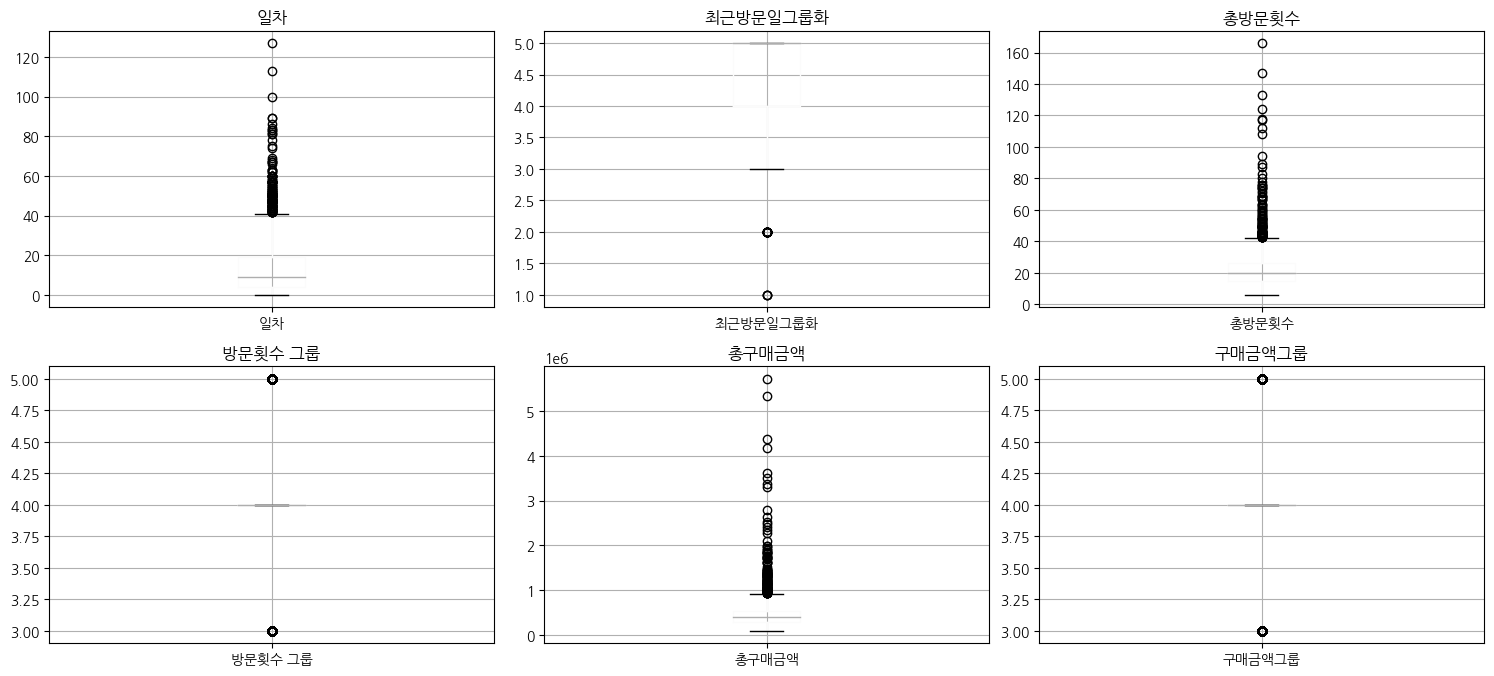

In [ ]:
# 박스 플롯 그리기 (각 열별로 개별 플롯)
columns = ['일차', '최근방문일그룹화', '총방문횟수', '방문횟수 그룹', '총구매금액', '구매금액그룹']
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    df_gold.boxplot(column=[col])
    plt.title(col)

plt.tight_layout()
plt.show()


### 최종 열매 등급 결과
- vip등급의 일자 커트라인 127
- 횟수 6
- 금액 1.006040e+05

## (3) 잎새

In [ ]:
df_silver = df[df["등급"]=="잎새"]

In [ ]:
df_silver.describe()

,회원번호,연령,일차,최근방문일그룹화,총방문횟수,방문횟수 그룹,총구매금액,구매금액그룹,RFM_Score,VIP점수,점수
count,3.462000e+03,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3.462000e+03,3462.000000,3462.000000,3462.000000,3462.000000
mean,8.465862e+08,49.410456,44.851531,3.453495,7.048238,2.594743,1.383983e+05,2.686886,8.735124,2.855281,2.855281
std,4.461567e+08,11.685612,49.293980,1.367685,3.695697,0.662363,9.655167e+04,0.710792,1.481867,0.462081,0.462081
min,1.876416e+07,25.000000,0.000000,1.000000,1.000000,1.000000,2.010000e+03,1.000000,6.000000,2.071000,2.071000
25%,4.825066e+08,41.000000,12.000000,3.000000,4.000000,2.000000,7.467275e+04,2.000000,8.000000,2.461000,2.461000
50%,8.177740e+08,47.000000,29.000000,4.000000,6.000000,3.000000,1.185275e+05,3.000000,9.000000,2.834000,2.834000
75%,1.214164e+09,56.000000,57.000000,5.000000,9.000000,3.000000,1.771790e+05,3.000000,10.000000,3.265000,3.265000
max,1.670621e+09,108.000000,290.000000,5.000000,29.000000,5.000000,1.072750e+06,5.000000,11.000000,3.623000,3.623000


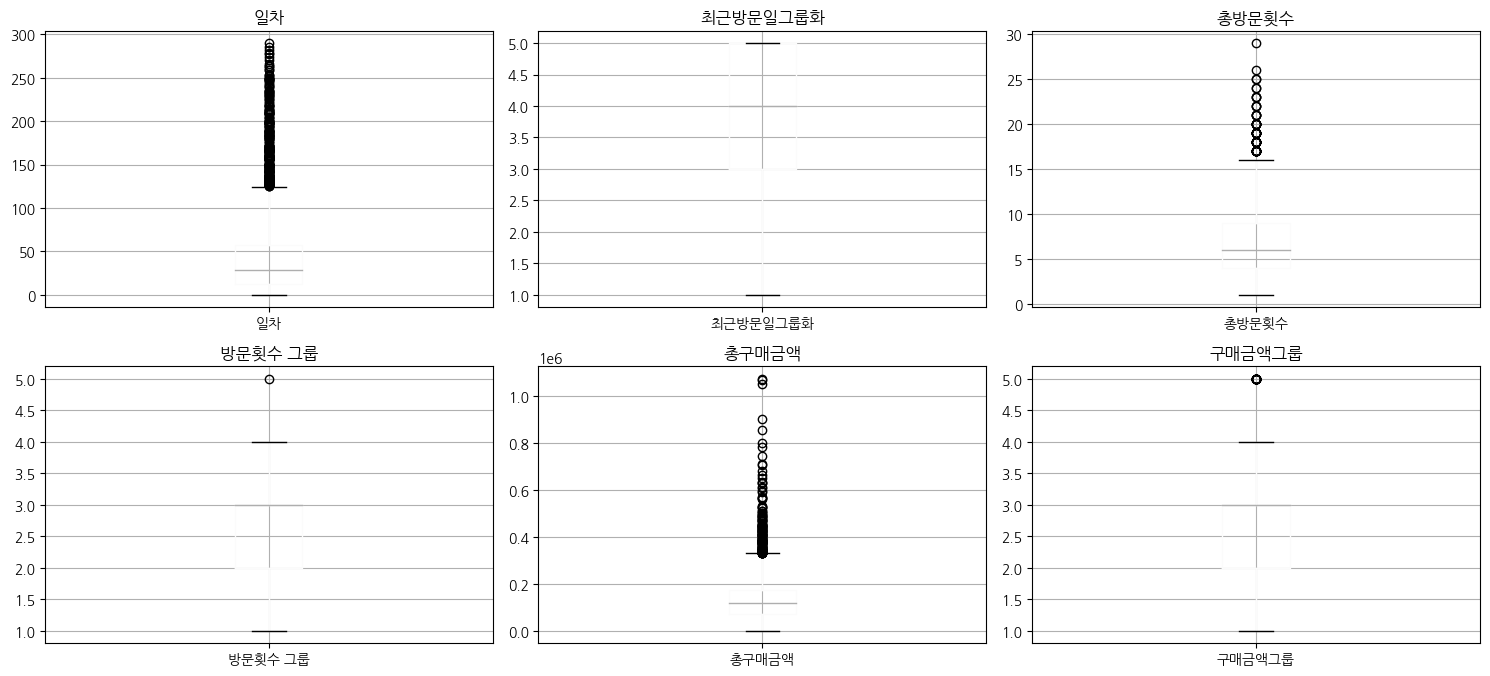

In [ ]:
# 박스 플롯 그리기 (각 열별로 개별 플롯)
columns = ['일차', '최근방문일그룹화', '총방문횟수', '방문횟수 그룹', '총구매금액', '구매금액그룹']
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    df_silver.boxplot(column=[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### 잎새 열매 등급 결과
- silver등급의 일자 커트라인 0
- 횟수 1
- 금액 1.149000e+03

## (4) 새싹

In [ ]:
df_Bronze = df[df["등급"]=="새싹"]

In [ ]:
df_Bronze.describe()

,회원번호,연령,일차,최근방문일그룹화,총방문횟수,방문횟수 그룹,총구매금액,구매금액그룹,RFM_Score,VIP점수,점수
count,4.616000e+03,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000
mean,8.443897e+08,48.759099,145.878033,1.623267,1.699307,1.175260,30256.362435,1.305893,4.104419,1.340917,1.340917
std,4.426150e+08,11.285981,84.321007,1.076073,1.030482,0.381936,27773.960813,0.509515,1.195121,0.357093,0.357093
min,1.861382e+07,24.000000,0.000000,1.000000,1.000000,1.000000,766.000000,1.000000,3.000000,0.999000,0.999000
25%,4.823067e+08,40.000000,73.000000,1.000000,1.000000,1.000000,10338.000000,1.000000,3.000000,0.999000,0.999000
50%,8.180765e+08,47.000000,138.000000,1.000000,1.000000,1.000000,22207.500000,1.000000,4.000000,1.267000,1.267000
75%,1.205147e+09,55.000000,218.000000,2.000000,2.000000,1.000000,40227.000000,2.000000,5.000000,1.640000,1.640000
max,1.644958e+09,107.000000,302.000000,5.000000,6.000000,3.000000,241024.000000,3.000000,7.000000,2.071000,2.071000


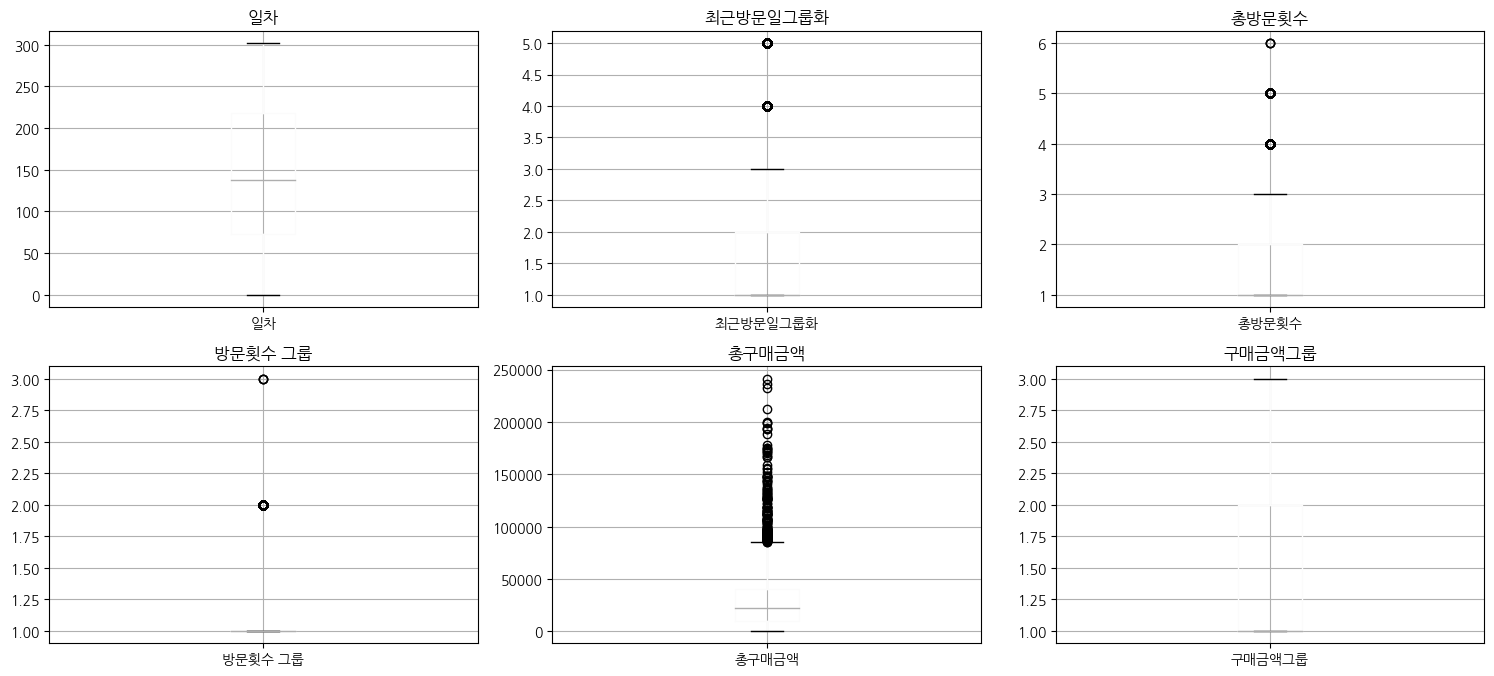

In [ ]:
# 박스 플롯 그리기 (각 열별로 개별 플롯)
columns = ['일차', '최근방문일그룹화', '총방문횟수', '방문횟수 그룹', '총구매금액', '구매금액그룹']
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    df_Bronze.boxplot(column=[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### 새싹 열매 등급 결과
- bronze등급의 일자 커트라인 0
- 횟수 6
- 금액 241024.000000